In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from tqdm import tqdm

In [20]:
def sigmoid(x, alpha):
    z = np.exp(-x+alpha)
    sig = 1 / (1 + z)
    return sig

In [21]:
#Height, weight, age
mu = [180,80,40]
sigma_all_corr = [[20**2, 240, 100],[240,15**2,45],[100,45,10**2]]
sigma_no_cross = [[20**2, 240, 100],[240,15**2,0],[100,0,10**2]]

In [22]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [23]:
print(is_pos_def(sigma_no_cross))
print(is_pos_def(sigma_all_corr))

True
True


In [24]:
data_cross_corr = np.random.multivariate_normal(mu ,sigma_all_corr, size = 1000)
data_no_cross = np.random.multivariate_normal(mu ,sigma_no_cross, size = 1000)

In [25]:
def random_missing_distr(data):
    missing = np.random.binomial(n = 1, p=0.3, size = 1000)
    y_o = [d for d, m in zip(data[:,0], missing) if m ==0]
    y_m = [d for d, m in zip(data[:,0], missing) if m ==1]
    print(np.mean(y_o), np.std(y_o))
    print(np.mean(y_m), np.std(y_m))
    plt.hist(y_o)
    plt.show()
    plt.hist(y_m)
    plt.show()

def mar_missing_distr(data):
    y_o = [d for d, m in zip(data[:,0], data[:,1]) if m <=102.5] #1.5std
    y_m = [d for d, m in zip(data[:,0], data[:,1]) if m >=102.5]
    print(np.mean(y_o), np.std(y_o))
    print(np.mean(y_m), np.std(y_m))
    plt.hist(y_o)
    plt.show()
    plt.hist(y_m)
    plt.show()

179.3166729647005 20.691438112663384
180.29084775620134 20.675266443234598


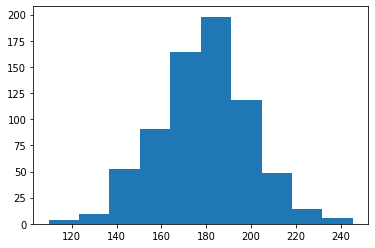

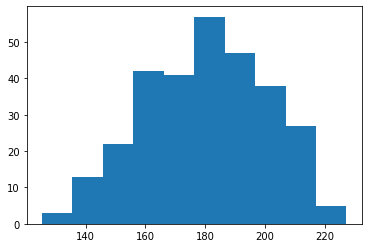

180.1011110797294 19.57458507515613
180.64366019178397 19.097181836086776


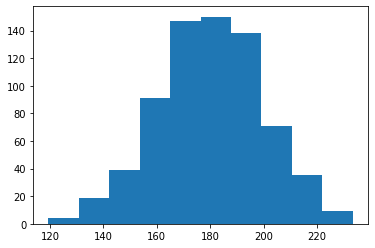

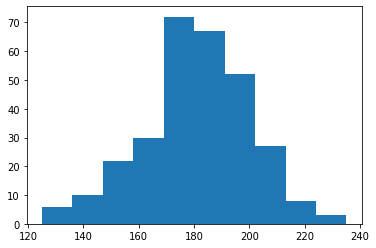

In [26]:
random_missing_distr(data_cross_corr)
random_missing_distr(data_no_cross)

177.1711371658167 19.155960290051343
210.0483988195537 13.886902715421114


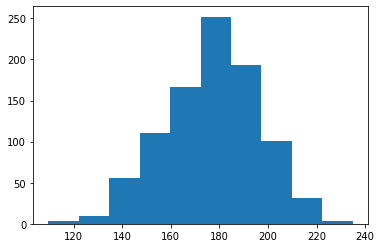

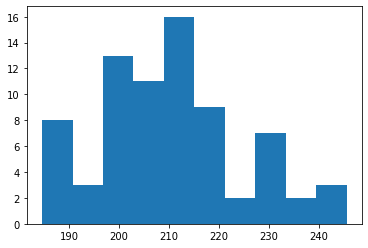

178.53716162139523 18.369848110156227
209.9023715234745 11.847012308266827


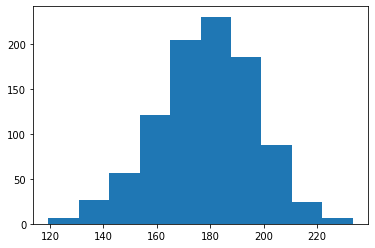

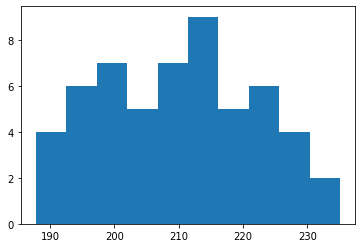

In [27]:
mar_missing_distr(data_cross_corr)
mar_missing_distr(data_no_cross)

In [28]:
#Categorical data
x_1 = np.random.normal(40, 10, size = 10000)
x_2 = np.random.binomial(1,0.65, size = 10000)
y = np.around(sigmoid(x_1+x_2*20, alpha = 50)).astype(int)
synth_cat = pd.DataFrame({"y": y, "x_1":x_1, "x_2":x_2})
synth_cat_test = synth_cat.iloc[:3000,:]
synth_cat_train = synth_cat.iloc[3000:,:]

In [29]:
sum(np.array(synth_cat_test["y"]))

1790

In [30]:
def confusion_matrix(true, pred):
    #Assumes numpy arrays(
    try: tpr = sum([1 if t == p and p==1 else 0 for t,p in zip(true, pred)])/(sum(true))
    except: 
        tpr = 0
        #print("true", sum(true))
        #print("pred", sum(pred))

    try: tnr = sum([1 if t == p and p==0 else 0 for t,p in zip(true, pred)])/(len(true)-sum(true))
    except: 
        tnr = 0
        #print("true", sum(true))
        #print("pred", sum(pred))
    fpr = 1-tnr
    fnr = 1-tpr
    return pd.DataFrame({"Predicted true": [tpr, fpr],
        "Predicted false": [fnr, tnr]}, index=["Is true", "Is false"])

In [31]:
from sklearn.linear_model import LogisticRegression
def data_remover(full_data, missing_col, missing_pct):
    data = full_data.copy()
    x = data.drop(missing_col, axis = 1)
    clf = LogisticRegression(random_state=0).fit(x, data[missing_col])
    probs = clf.predict_proba(x)[:,1]
    #print(probs)
    lower_percentile = np.percentile(probs, missing_pct//2)
    upper_percentile = np.percentile(probs, 100-missing_pct//2)
    data["probs"] = probs
    data = data[data["probs"]>= lower_percentile]
    data = data[data["probs"]<= upper_percentile]
    data.drop("probs", axis = 1, inplace = True)
    return data




In [32]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

#TODO figure out a good set of hyperparameters and a response on how to tune them
# Perhaps irrelevant since we are looking at difference in performance due to missing data?
init_models = {"log_reg": LogisticRegression(random_state=0, max_iter=300),
    "lin_reg":LinearRegression(),
    "svm":LinearSVC(random_state=0, tol=1e-5),
    "knn":KNeighborsClassifier(n_neighbors=3),
    "rf_cat": RandomForestClassifier(max_depth=4, random_state=0),
    "rf_cont": RandomForestRegressor(max_depth=4, random_state=0)}
    
def test_bench(train, test, pred, missing, pred_var_type="cat", miss_var_type="cat"):
    #Currently only works for categorical missing and  predictor variables
    #Qauntile
    class_0_test = test[test[missing]==0]
    class_1_test = test[test[missing]==1]

    #print("class_0",sum(class_0_test[pred]))
    #print("class_1",sum(class_1_test[pred]))
    results = {}
    percentiles = [i for i in range(1,16)]+[j for j in range(20, 100, 10)]

    #TODO add xgboost, neural network
    if pred_var_type =="cat":
        models = ["log_reg", "rf_cat", "svm", "knn"]
    else:
        models = ["lin_reg", "rf_cont", "svm"] 
    #Run with full data
    
    for m in models:
        predictions_0 = init_models[m].fit(train.drop(pred, axis = 1),
            train[pred]).predict(class_0_test.drop(pred, axis = 1))
        predictions_1 = init_models[m].fit(train.drop(pred, axis = 1),
            train[pred]).predict(class_1_test.drop(pred, axis = 1))
        results[m+"_0"] = confusion_matrix(class_0_test[pred], predictions_0)
        results[m+"_1"] = confusion_matrix(class_1_test[pred], predictions_1)
        for p in percentiles:
            mcar = np.random.binomial(n=1, p=p/100, size = len(train))
            data_mcar = train.copy()
            data_mcar["missing"] = mcar
            data_mcar = data_mcar[data_mcar["missing"]==0]
            data_mcar.drop("missing", axis = 1, inplace = True)
            #print("length", len(data_mcar))

            predictions_0 = init_models[m].fit(data_mcar.drop(pred, axis = 1),
            data_mcar[pred]).predict(class_0_test.drop(pred, axis = 1))
            predictions_1 = init_models[m].fit(data_mcar.drop(pred, axis = 1),
            data_mcar[pred]).predict(class_1_test.drop(pred, axis = 1))
            results[m+"_mcar_"+str(p)+"_0"] = confusion_matrix(class_0_test[pred], predictions_0)
            results[m+"_mcar_"+str(p)+"_1"] = confusion_matrix(class_1_test[pred], predictions_1)

            data_mar = data_remover(train, missing, p)
            #print("sum", sum(np.array(data_mar["y"])), "length", len(data_mar))
            
            predictions_0 = init_models[m].fit(data_mar.drop(pred, axis = 1),
            data_mar[pred]).predict(class_0_test.drop(pred, axis = 1))
            predictions_1 = init_models[m].fit(data_mar.drop(pred, axis = 1),
            data_mar[pred]).predict(class_1_test.drop(pred, axis = 1))
            results[m+"_mar_"+str(p)+"_0"] = confusion_matrix(class_0_test[pred], predictions_0)
            results[m+"_mar_"+str(p)+"_1"] = confusion_matrix(class_1_test[pred], predictions_1)
    return results

        

        

In [33]:
synth_cat_train

,y,x_1,x_2
3000,1,40.977676,1
3001,1,42.166803,1
3002,1,32.404145,1
3003,0,31.068890,0
3004,1,40.867674,1
...,...,...,...
9995,0,42.058562,0
9996,1,43.815432,1
9997,0,34.264036,0
9998,0,26.384512,0


In [34]:
res = test_bench(synth_cat_train, synth_cat_test, "y", "x_2")

C:\Users\mariu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\mariu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\mariu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\mariu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\mariu\AppData\Local\Program

In [35]:
import collections
def plotting(models, results):
    for m in models:
        tpr_mar = {"0":{}, "1": {}}
        tnr_mar = {"0":{}, "1": {}}
        tpr_mcar = {"0":{}, "1": {}}
        tnr_mcar = {"0":{}, "1": {}}
        for key, value in results.items():
            
            if m+"_mar" in key:
                
                if key[-1] =="0":
                    tpr_mar["0"][int(key.split("_")[-2])] = value.iloc[0,0]
                    tnr_mar["0"][int(key.split("_")[-2])] = value.iloc[1,1]
                else:
                    tpr_mar["1"][int(key.split("_")[-2])] = value.iloc[0,0]
                    tnr_mar["1"][int(key.split("_")[-2])] = value.iloc[1,1]
            elif m+"_mcar" in key:
                if key[-1] =="0":
                    tpr_mcar["0"][int(key.split("_")[-2])] = value.iloc[0,0]
                    tnr_mcar["0"][int(key.split("_")[-2])] = value.iloc[1,1]
                else:
                    tpr_mcar["1"][int(key.split("_")[-2])] = value.iloc[0,0]
                    tnr_mcar["1"][int(key.split("_")[-2])] = value.iloc[1,1]
        tpr_mar = collections.OrderedDict(sorted(tpr_mar.items()))
        plt.plot(list(tpr_mar["0"].keys()), list(tpr_mar["0"].values()), label = m+"TPR MAR class 0")
        plt.plot(list(tnr_mar["0"].keys()), list(tnr_mar["0"].values()), label = m+"TNR MAR class 0")
        plt.plot(list(tpr_mar["1"].keys()), list(tpr_mar["1"].values()), label = m+"TPR MAR class 1")
        plt.plot(list(tnr_mar["1"].keys()), list(tnr_mar["1"].values()), label = m+"TNR MAR class 1")
        plt.title(m+"_MAR")
        plt.legend()
        plt.show()
        plt.plot(list(tpr_mcar["0"].keys()), list(tpr_mcar["0"].values()), label = m+"TPR MCAR class 0")
        plt.plot(list(tnr_mcar["0"].keys()), list(tnr_mcar["0"].values()), label = m+"TNR MCAR class 0")
        plt.plot(list(tpr_mcar["1"].keys()), list(tpr_mcar["1"].values()), label = m+"TPR MCAR class 1")
        plt.plot(list(tnr_mcar["1"].keys()), list(tnr_mcar["1"].values()), label = m+"TNR MCAR class 1")
        plt.title(m+"_MCAR")
        plt.legend()
        plt.show()


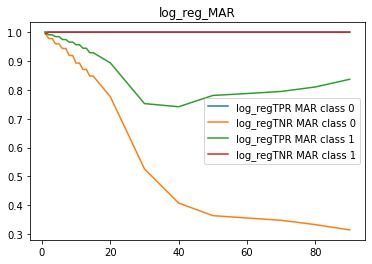

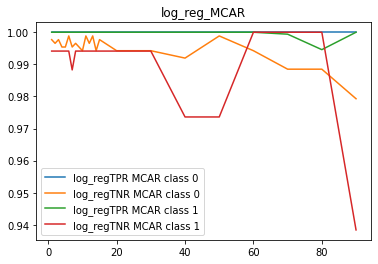

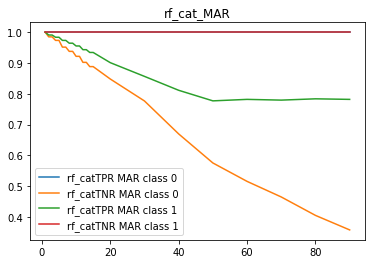

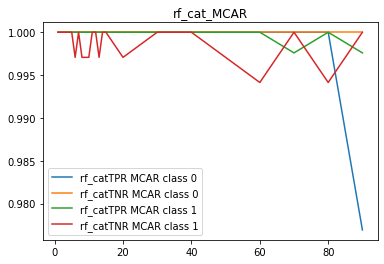

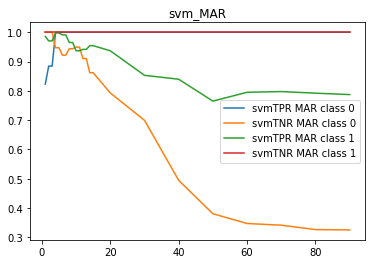

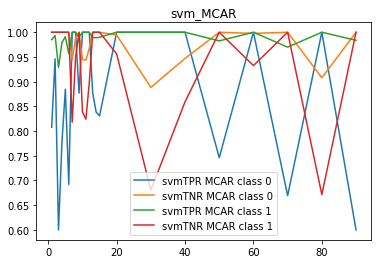

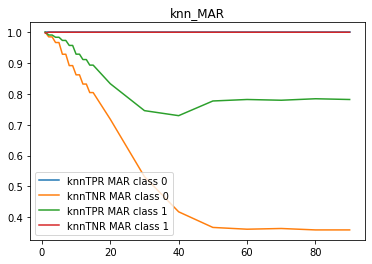

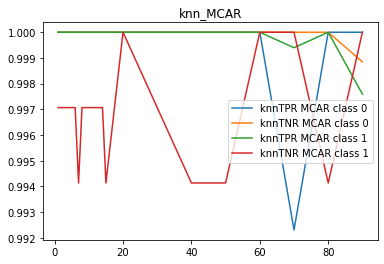

In [36]:
plotting(["log_reg", "rf_cat", "svm", "knn"], res)